# MAP parameter estimation for an LG-SSM using EM and SGD

This notebook shows how to "fit" a linear Gaussian SSM &mdash; i.e., estimate the parameters and infer the latent states &mdash; using either expectation-maximization (EM) or stochastic gradient descent (SGD) on the negative log marginal likelihood of the data. 

Here, we work with simulate noisy data from an LG-SSM with known parameters, and then we see how well we can recover the true parameters and states given the observations. The model is,
\begin{align*}
z_{t+1} \mid z_t, \theta &\sim \mathrm{N}(F z_t, Q) \\
y_t \mid z_t, \theta &\sim \mathrm{N}(H z_t, R)
\end{align*}
where $z_{1:T}$ are the latent states, $y_{1:T}$ are the emissions, and $\theta = (F, Q, H, R)$ are the model parameters. In particular, $F$ is the dynamics matrix and $H$ is the emission matrix. For our simulation, we use 2-dimensional latent states, $z_t \in \mathbb{R}^2$, and 10-dimensional emissions, $y_t \in \mathbb{R}^10$. 

We fit the model to estimate parameters, $\hat{\theta}$, using either EM or SGD, as shown below. Once we have estimated the paraemeters, we can also infer the latent states given those parameters.


## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
import jax.numpy as jnp
import jax.random as jr

from jax import vmap
from matplotlib import pyplot as plt

from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.utils.utils import monotonically_increasing

## Data

Simulate 2-dimensional latent states and 10-dimensionl emissions from a linear Gaussian SSM with randomly initialized parameters. By default, `initialize` sets the dynamics matrix to $F = 0.99 I$ so that the dynamics are a stable, slowly decaying random walk. 


In [3]:
state_dim = 2
emission_dim = 10
num_timesteps = 100
key = jr.PRNGKey(0)

# Construct the true model with randomly initialized parameters
# Note: the dynamis matrix is initialized to 0.99 * I to ensure stability
true_model = LinearGaussianSSM(state_dim, emission_dim)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(key)

# Sample states and emissions from the true model
key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps)

## Visualizing the states, emissions, and model-based inferences

Before fitting a model, we show how you can use a model to inspect latent states and reconstruct or denoise the emissions.

Given noisy emissions, $y_{1:T}$, and parameters, $\theta$, we can compute the posterior mean of the latent states, 
\begin{align*}
\mu_{t|T} \triangleq \mathbb{E}[z_{t} \mid y_{1:T}; \theta],
\end{align*} 
using a Kalman smoother. (The `model.smoother` function returns the posterior distribution over latent states.) The function below plots this posterior alongside the true latent states. 

We can also reconstruct the emissions by passing the posterior mean over states through the emission distribution to obtain,
\begin{align*}
\hat{y}_t 
&= \mathbb{E}_{z_t \mid y_{1:T}; \theta}[H z_t] \\
&= H \mu_{t|T}.
\end{align*}
Similarly, we can compute the covariance of the reconstruction as,
\begin{align*}
\widehat{\mathbb{V}[y_t]}
&= \mathbb{V}_{z_t \mid y_{1:T}; \theta}[H z_t + \epsilon_t] \\
&= H \Sigma_{t|T} H^\top + R,
\end{align*}
where $\epsilon_t \sim \mathrm{N}(0, R)$ is the emission noise and $\Sigma_{t|T} = \mathbb{V}[z_t \mid y_{1:T}; \theta]$ is the posterior marginal covariance. 

These quantities are computed by the `model.posterior_predictive` function, as illustrated below. Note that the term _posterior predictive_ distribution can be ambiguous. Here we refer to the predictive distribution of _current_ emissions $y_{1:T}$ under the posterior distribution $p(z_{1:T} \mid y_{1:T}; \theta)$. Another type of posterior prediction is over _future_ latent states and emissions.

In [4]:
def plot_states_and_emissions(model, params, emissions, true_states, spc=3):
    """
    Plot the true and inferred latent states, and the 
    true and reconstructed/denoised emissions. 
    """
    posterior = model.smoother(params, emissions)
    smoothed_states = posterior.smoothed_means
    smoothed_states_std = jnp.sqrt(vmap(jnp.diag)(posterior.smoothed_covariances))
    recon_emissions, recon_emissions_std = model.posterior_predictive(params, emissions)

    fig, axs = plt.subplots(2, 1, height_ratios=[state_dim, emission_dim], sharex=True)
    
    # Plot the latent states
    for i in range(state_dim):
        ln = axs[0].plot(smoothed_states[:, i] + spc * i, label="smoothed" if i == 0 else None)[0]
        # axs[0].axhline(i * spc, color="black", linestyle=":", alpha=0.5)
        axs[0].fill_between(
            jnp.arange(num_timesteps),
            spc * i + smoothed_states[:, i] - 2 * smoothed_states_std[:, i],
            spc * i + smoothed_states[:, i] + 2 * smoothed_states_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
        axs[0].plot(true_states[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    axs[0].set_ylabel("states")
    axs[0].set_yticks(spc * jnp.arange(state_dim))
    axs[0].set_yticklabels([f"dim. {i}" for i in jnp.arange(state_dim)])
    axs[0].grid(True)
    
    # Plot the emissions
    for i in range(emission_dim):
        # axs[1].axhline(i *spc, color="black", linestyle=":", alpha=0.5)
        ln = axs[1].plot(recon_emissions[:, i] + spc * i, label="reconstructed" if i == 0 else None)[0]
        axs[1].fill_between(
            jnp.arange(num_timesteps),
            spc * i + recon_emissions[:, i] - 2 * recon_emissions_std[i],
            spc * i + recon_emissions[:, i] + 2 * recon_emissions_std[i],
            color=ln.get_color(),
            alpha=0.25,
        )
        axs[1].plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    axs[1].set_xlabel("time")
    axs[1].set_xlim(0, num_timesteps - 1)
    axs[1].set_ylabel("emissions")
    axs[1].set_yticks(spc * jnp.arange(emission_dim))
    axs[1].set_yticklabels([f"dim. {i}" for i in jnp.arange(emission_dim)])
    axs[1].legend()
    axs[1].grid(True)
    plt.tight_layout()

First, plot the reconstructions under the true model.

Text(0.5, 1.02, 'true model')

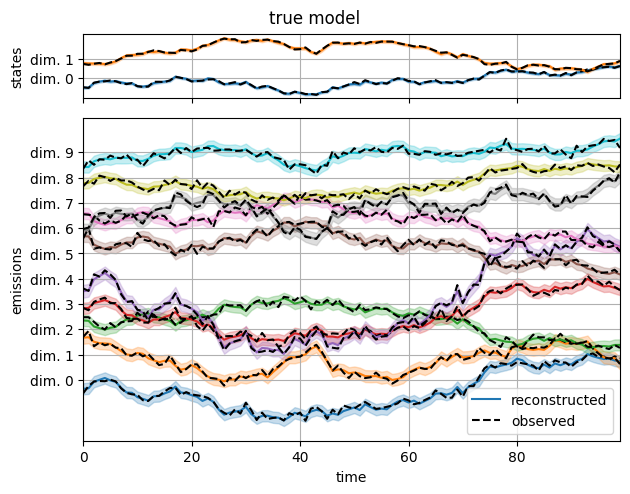

In [5]:
plot_states_and_emissions(true_model, true_params, emissions, true_states)
plt.suptitle("true model", y=1.02)

Now plot the reconstructions under a randomly initialized model. They're much worse! 

In [6]:
# Plot predictions from a random, untrained model
model = LinearGaussianSSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
params, param_props = model.initialize(key)

Text(0.5, 1.02, 'randomly initialized model')

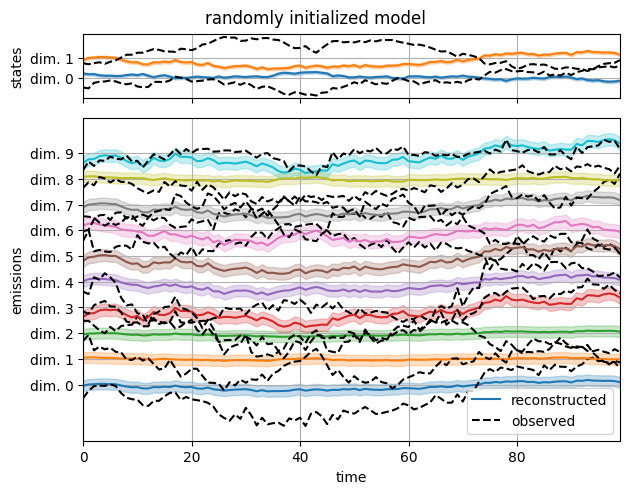

In [7]:
plot_states_and_emissions(model, params, emissions, true_states)
plt.suptitle("randomly initialized model", y=1.02)

## Fit with EM

Let's fit the model to the data using expectation-maximization (EM) algorithm. As with hidden Markov models, EM alternates between inferring the latent states (E-step) and then maximizing the expected log probability of the states and emissions (M-step). The E-step is implemented with a Kalman smoother. The M-step has a closed form solution for linear Gaussian state space models, so the algorithm is very efficient!

In [8]:
params, marginal_lls = model.fit_em(params, param_props, emissions, num_iters=100)
assert monotonically_increasing(marginal_lls, atol=1e-2, rtol=1e-2)

We zoom in on the learning curve after the first iteration since the first log likelihood is much lower than the rest.

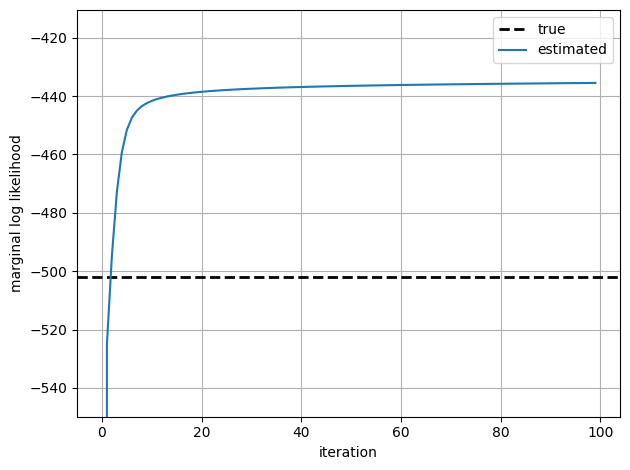

In [9]:
true_ll = true_model.marginal_log_prob(true_params, emissions)
plt.axhline(true_ll, color = 'k', linestyle = '--', lw=2, label="true")
plt.plot(marginal_lls, '-', ms=4, label="estimated")
plt.xlabel("iteration")
plt.ylabel("marginal log likelihood")
plt.ylim(marginal_lls[1] - 25, marginal_lls[-1] + 25)
plt.legend()
plt.tight_layout()
plt.grid(True)

The marginal log likelihood quickly converges. As with the HMM examples, the likelihood under the estimated parameters is larger than the likelihood under the true parameters that generated the data. This isn't surprising: EM is finding the parameters $\hat{\theta}_{\mathsf{MLE}}$, that maximize the likelihood, and with a short sequence like this, the likelihood $p(x_{1:T}; \hat{\theta}_{\mathsf{MLE}})$ is almost surely larger than $p(x_{1:T}; \theta_{\mathsf{true}})$.

Last but not least, reconstructing the data with the estimated parameters yields nice predictions.

Text(0.5, 1.02, 'fitted model')

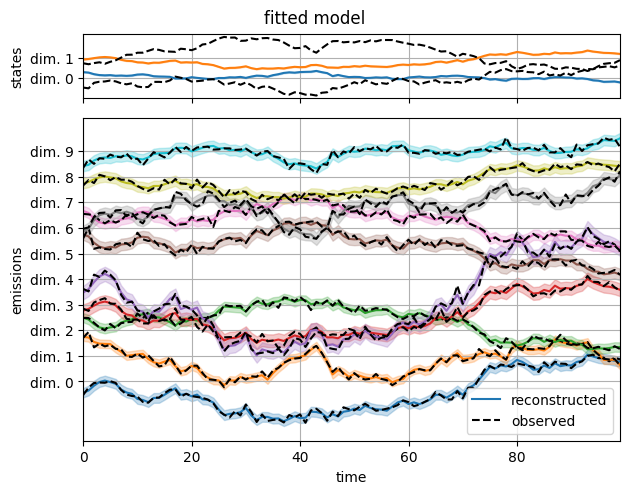

In [10]:
plot_states_and_emissions(model, params, emissions, true_states)
plt.suptitle("fitted model", y=1.02)

### Identifiability

Notice how the fitted model is able to reconstruct the emissions, but the inferred latent states do not match the true latent states. That's because the latent state are only identifiable up to an orthogonal transformation. We can always map $z_t \mapsto A z_t$ where $A$ is an orthogonal matrix, and then account for the transformation with a commensurate change in the parameters. 

## Fit with SGD

As with HMMs, we can also fit the model parameters by using (stochastic) gradient descent on the negative marginal log likelihood. You can use an optimizer of your choice, like Adam. You'll have to explore various learning rates (and possibly other hyperparameters as well). We recommend that you start with EM since it tends to converge more quickly, but currently SGD supports some features that EM doesn't. For example, SGD allows you to fix certain parameters during training.

In [11]:
from optax import adam
learning_rates = [1e-2, 1e-1, 2.5e-1]
all_sgd_params = []
all_sgd_marginal_lls = []
for lr in learning_rates:
    print(f"fitting with Adam and learning rate {lr}")
    optimizer = adam(learning_rate=lr)
    sgd_params, sgd_param_props = model.initialize(key)
    sgd_params, losses = model.fit_sgd(
        sgd_params, sgd_param_props, emissions, num_epochs=1000, optimizer=optimizer)
    sgd_marginal_lls = -losses * emissions.size
    all_sgd_marginal_lls.append(sgd_marginal_lls)
    all_sgd_params.append(params)


fitting with Adam and learning rate 0.01
fitting with Adam and learning rate 0.1
fitting with Adam and learning rate 0.25


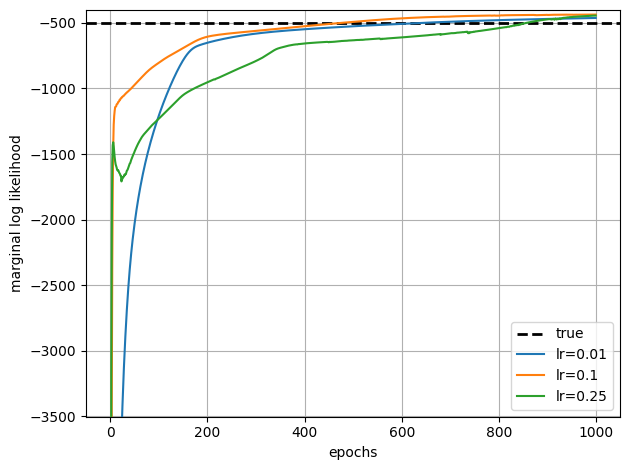

In [12]:
# Plot the SGD learning curves and the true LL for comparison
true_ll = true_model.marginal_log_prob(true_params, emissions)
plt.axhline(true_ll, color = 'k', linestyle = '--', lw=2, label="true")
for lr, lls in zip(learning_rates, all_sgd_marginal_lls):
    plt.plot(lls, '-', ms=4, label=f"lr={lr}")
plt.xlabel("epochs")
plt.ylabel("marginal log likelihood")
plt.ylim(true_ll - 3000, true_ll + 100)
plt.legend()
plt.tight_layout()
plt.grid(True)

Adam eventually converges, but note that both the y-axis and x-axis scales are much larger than for EM. It takes 100s of epochs to achieve comparable log likelihoods, and each epoch is roughly the equivalent cost to one iteration of EM. 

### Freezing parameters

Now let's fit an LG-SSM with certain parameters held fixed. For example, the code below freezes the dynamics to their initial values, which happen to coincide with the true dynamics weights.

In [13]:
from optax import adam
optimizer = adam(learning_rate=1e-2)
sgd_params, sgd_param_props = model.initialize(key)

print(f"freeing the dynamics matrix to:\n {sgd_params.dynamics.weights}")
sgd_param_props.dynamics.weights.trainable = False

# Fit the model with SGD
sgd_params, losses = model.fit_sgd(
    sgd_params, sgd_param_props, emissions, num_epochs=1000, optimizer=optimizer)
sgd_marginal_lls = -losses * emissions.size

# Check that the dynamics matrix has not been updated
assert jnp.allclose(sgd_params.dynamics.weights, 0.99 * jnp.eye(state_dim))

freeing the dynamics matrix to:
 [[0.99 0.  ]
 [0.   0.99]]


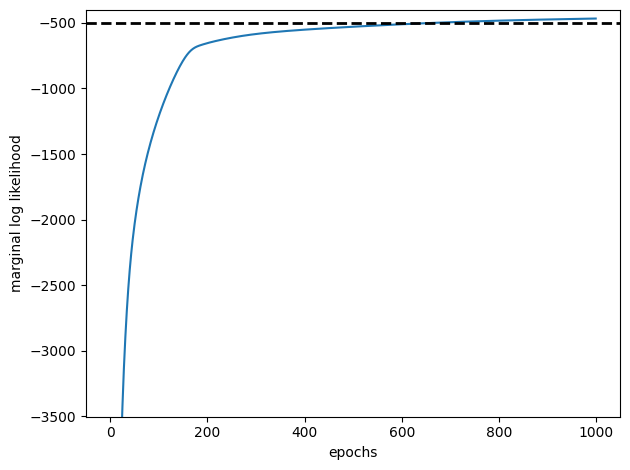

In [14]:
# Plot the SGD learning curve and the true LL for comparison
plt.plot(sgd_marginal_lls, '-', ms=4, label="estimated")
plt.axhline(true_ll, color = 'k', linestyle = '--', lw=2, label="true")
plt.xlabel("epochs")
plt.ylabel("marginal log likelihood")
plt.ylim(true_ll - 3000, true_ll + 100)
plt.tight_layout()

## Conclusion

This notebook shows how to fit linear Gaussian state space models (i.e., linear dynamical systems) using either EM or SGD, and how to use the fitted parameters to infer latent states and denoise the data. You can use the parameters for several other tasks as well. For example,
- You can compute the filtering of the latent states using the `model.filter` function. 
- You can sample new states and observations from the fitted model and use them, for example, to forecast new observations. 
- You can study the system dynamics and their properties in `params.dynamics`.

The next notebook shows how to do Bayesian inference of the parameters using Hamiltonian Monte Carlo.